<a href="https://colab.research.google.com/github/shashankbansal6/collab_projects/blob/master/nobrainer_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a neural network with very little data

In this notebook, we will use Nobrainer to train a model with limited data. We will start off with a pre-trained model. You can find available pre-trained Nobrainer models at https://github.com/neuronets/nobrainer-models.

The pre-trained models can be used to train models for the same task as they were trained for or to transfer learn a new task. For instance, a pre-trained brain extraction model can be re-trained for tumor labeling. In this notebook, we will train a brain extraction model, but keep in mind that you can retrain these models for many 3D semantic segmentation tasks.

In the following cells, we will:

1. Get sample T1-weighted MR scans as features and FreeSurfer segmentations as labels.
    - We will binarize the FreeSurfer to get a precise brainmask.
2. Convert the data to TFRecords format.
3. Create two Datasets of the features and labels.
    - One dataset will be for training and the other will be for evaluation.
4. Load a pre-trained 3D semantic segmentation model.
5. Choose a loss function and metrics to use.
6. Train on part of the data.
7. Evaluate on the rest of the data.

## Google Colaboratory

If you are using Colab, please switch your runtime to GPU. To do this, select `Runtime > Change runtime type` in the top menu. Then select GPU under `Hardware accelerator`. A GPU greatly speeds up training.

# Install nobrainer

In [1]:
!pip install nibabel
!pip install imgaug
!pip install numpy
!pip install tqdm
!pip install keras
!pip install https://github.com/neuronets/nobrainer/tarball/master
!pip install keract
!pip install tensorflow-gpu==1.14

     - 92kB 3.6MB/s
  Created wheel for nobrainer: filename=nobrainer-0+unknown-cp36-none-any.whl size=59902 sha256=cc2f0c7c543180dd6edf3a87e86df062f290df94b7ff9bae1ddd90b21fa24016
  Stored in directory: /tmp/pip-ephem-wheel-cache-znpr8wd2/wheels/48/56/60/cccb21415d3515fe6ab5e1809f0d7d070b61436063eb47dc31
Successfully built nobrainer
  Using cached https://files.pythonhosted.org/packages/b9/0c/0ca3bbf2dcba6ebaf8238438059816324c80c0b111640ffc5be259af7b4d/keract-2.8.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e5/e6/c3fdc53aed9fa19d6ff3abf97dfad768ae3afce1b7431f7500000816bda5/numpy-1.17.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'l

     |████████████████████████████████| 377.0MB 79kB/s 
     |████████████████████████████████| 491kB 46.8MB/s 
     |████████████████████████████████| 3.2MB 33.6MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [2]:
import nobrainer
import keract
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from keract import get_activations
print(tf.__version__)

1.14.0


Using TensorFlow backend.


# Get sample features and labels

We use 9 pairs of volumes for training and 1 pair of volumes for evaulation. Many more volumes would be required to train a model for any useful purpose.

In [3]:
csv_of_filepaths = nobrainer.utils.get_data()
filepaths = nobrainer.io.read_csv(csv_of_filepaths)

train_paths = filepaths[:9]
evaluate_paths = filepaths[9:]

335872/335557 [==============================] - 0s 0us/step


In [4]:
print(train_paths[0])
print(train_paths[0][0])
nib_vol = nib.load(train_paths[0][0])
vol_data = nib_vol.get_data()

('/tmp/nobrainer-data/datasets/sub-01_t1.mgz', '/tmp/nobrainer-data/datasets/sub-01_aparc+aseg.mgz')
/tmp/nobrainer-data/datasets/sub-01_t1.mgz


(256, 256, 256)
(128, 128, 128)


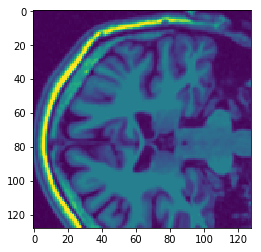

In [5]:
print(vol_data.shape)
vol_data = np.array(vol_data)
temp = vol_data[50:178,50:178,50:178]
print(temp.shape)
plt.show()
plt.imshow(temp[:, :, 64])

# Load pre-trained model

In [6]:
model_path = tf.keras.utils.get_file(
    fname='brain-extraction-unet-128iso-model.h5',
    origin='https://github.com/neuronets/nobrainer-models/releases/download/0.1/brain-extraction-unet-128iso-model.h5')

19177472/19169888 [==============================] - 0s 0us/step


In [7]:
model = tf.keras.models.load_model(model_path, compile=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 128 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 13856       activation[0][0]                 
_______________________________________________________________________________________________

# Considerations for transfer learning

Training a neural network changes the model's weights. A pre-trained network has learned weights for a task, and we do not want to forget these weights during training. In other words, we do not want to ruin the pre-trained weights when using our new data. To avoid dramatic changes in the learnable parameters, we can apply regularization and use a relatively small learning rate.

In [0]:
for layer in model.layers:
    layer.kernel_regularizer = tf.keras.regularizers.l2(0.001)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

model.compile(
    optimizer=optimizer,
    loss=nobrainer.losses.jaccard,
    metrics=[nobrainer.metrics.dice],
)

In [10]:
X = []
X.append(temp[..., None])
X = np.array(X)
print(X.shape)
activations = get_activations(model, X)

(1, 128, 128, 128, 1)



In [47]:
for k in activations:
  print(k, activations[k].shape)

input_1:0 (128, 128, 128, 1)
conv3d/BiasAdd:0 (1, 128, 128, 128, 16)
activation/Relu:0 (1, 128, 128, 128, 16)
conv3d_1/BiasAdd:0 (1, 128, 128, 128, 32)
activation_1/Relu:0 (1, 128, 128, 128, 32)
max_pooling3d/MaxPool3D:0 (1, 64, 64, 64, 32)
conv3d_2/BiasAdd:0 (1, 64, 64, 64, 32)
activation_2/Relu:0 (1, 64, 64, 64, 32)
conv3d_3/BiasAdd:0 (1, 64, 64, 64, 64)
activation_3/Relu:0 (1, 64, 64, 64, 64)
max_pooling3d_1/MaxPool3D:0 (1, 32, 32, 32, 64)
conv3d_4/BiasAdd:0 (1, 32, 32, 32, 64)
activation_4/Relu:0 (1, 32, 32, 32, 64)
conv3d_5/BiasAdd:0 (1, 32, 32, 32, 128)
activation_5/Relu:0 (1, 32, 32, 32, 128)
max_pooling3d_2/MaxPool3D:0 (1, 16, 16, 16, 128)
conv3d_6/BiasAdd:0 (1, 16, 16, 16, 128)
activation_6/Relu:0 (1, 16, 16, 16, 128)
conv3d_7/BiasAdd:0 (1, 16, 16, 16, 256)
activation_7/Relu:0 (1, 16, 16, 16, 256)
conv3d_transpose/BiasAdd:0 (1, 32, 32, 32, 256)
concatenate/concat:0 (1, 32, 32, 32, 384)
conv3d_8/BiasAdd:0 (1, 32, 32, 32, 128)
activation_8/Relu:0 (1, 32, 32, 32, 128)
conv3d_9/Bi

Activation/Relu:0 (1, 128, 128, 128, 16)
Conv maps


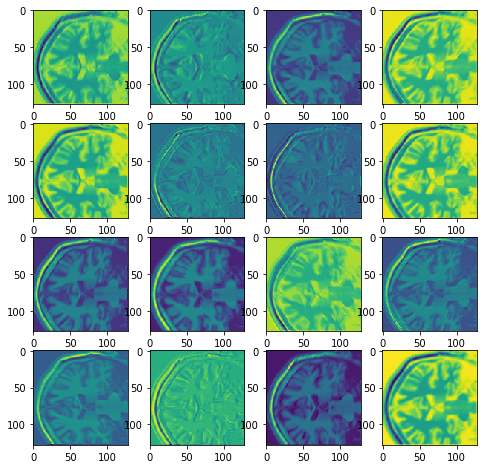

Activation maps


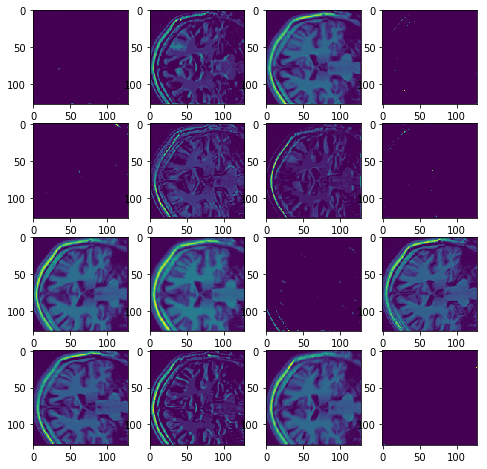

In [60]:
print("Activation/Relu:0", activations['activation/Relu:0'].shape)

w=10
h=10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
print("Conv maps")
for i in range(1, columns*rows+1):
    img = activations['conv3d/BiasAdd:0'][0, :, :, 64, i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

print("Activation maps")
fig2 = plt.figure(figsize=(8, 8))
for i in range(1, columns*rows+1):
    img = activations['activation/Relu:0'][0, :, :, 64, i-1]
    fig2.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

#plt.imshow(activations['activation/Relu:0'][0, :, :, 64, 5])

activation_1/Relu (1, 128, 128, 128, 32)


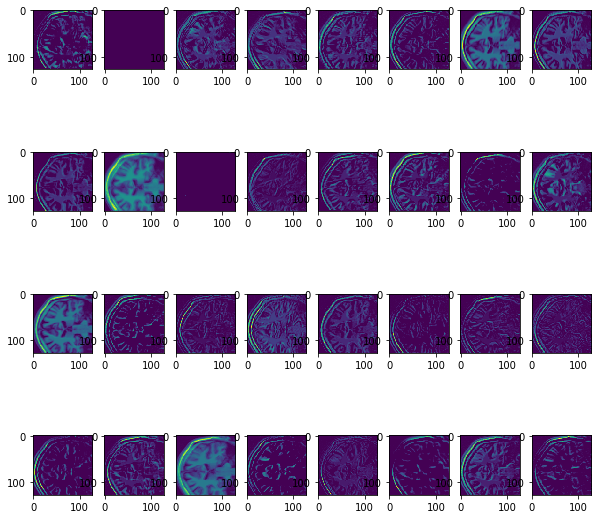

In [46]:
print("activation_1/Relu", activations['activation_1/Relu:0'].shape)

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 8
rows = 4
for i in range(1, columns*rows+1):
    img = activations['activation_1/Relu:0'][0, :, :, 64, i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

activation_2/Relu (1, 64, 64, 64, 32)


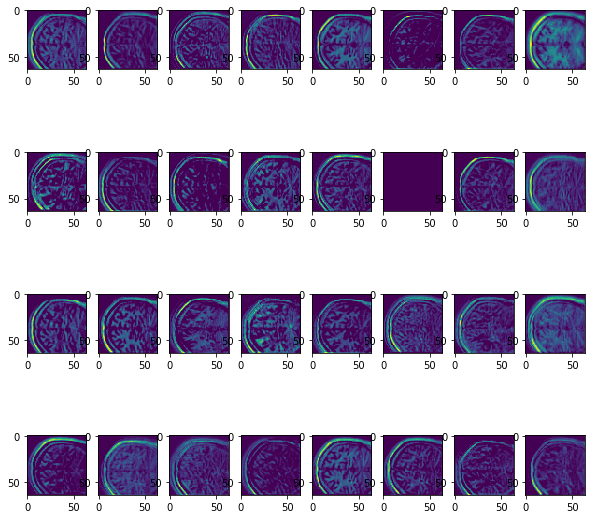

In [54]:
print("activation_2/Relu", activations['activation_2/Relu:0'].shape)

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 8
rows = 4
for i in range(1, columns*rows+1):
    img = activations['activation_2/Relu:0'][0, :, :, 16, i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

activation_3/Relu (1, 64, 64, 64, 64)


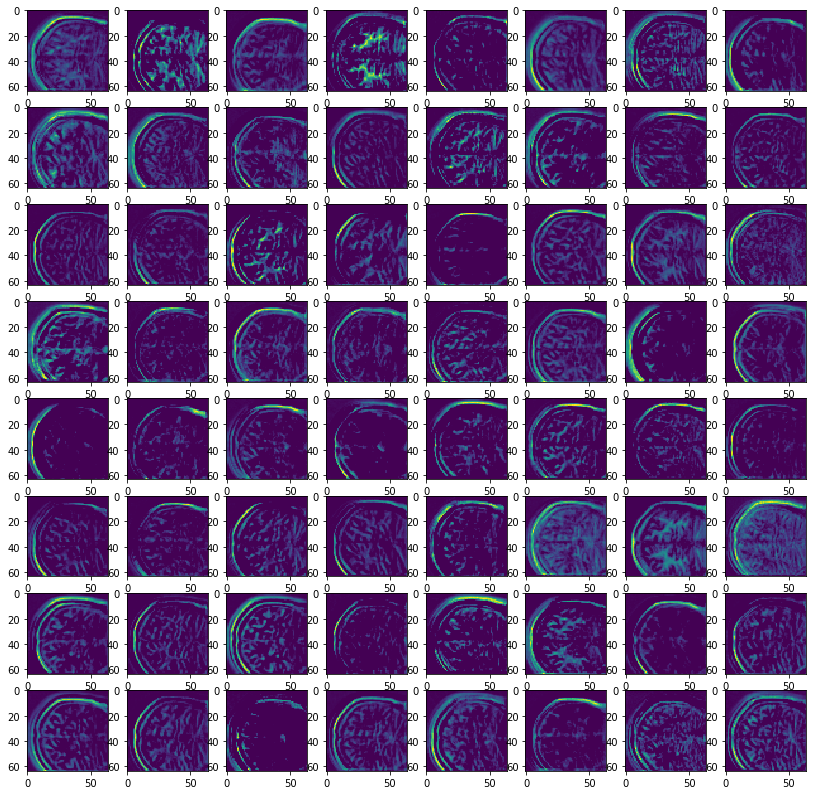

In [56]:
print("activation_3/Relu", activations['activation_3/Relu:0'].shape)

w=10
h=10
fig=plt.figure(figsize=(14, 14))
columns = 8
rows = 8
for i in range(1, columns*rows+1):
    img = activations['activation_3/Relu:0'][0, :, :, 16, i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()